# Task 1: Introduction

---

For this project, we are going to work on evaluating price of houses given the following features:

1. Year of sale of the house
2. The age of the house at the time of sale
3. Distance from city center
4. Number of stores in the locality
5. The latitude
6. The longitude

![Regression](images/regression.png)

Note: This notebook uses `python 3` and these packages: `tensorflow`, `pandas`, `matplotlib`, `scikit-learn`.

## 1.1: Importing Libraries & Helper Functions

First of all, we will need to import some libraries and helper functions. This includes TensorFlow and some utility functions that I've written to save time.

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from utils import *
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback

%matplotlib inline

print('Libraries imported.')

Libraries imported.


# Task 2: Importing the Data

## 2.1: Importing the Data

The dataset is saved in a `data.csv` file. We will use `pandas` to take a look at some of the rows.

In [5]:
df = pd.read_csv('data.csv', names = column_names) 
df.head()

,serial,date,age,distance,stores,latitude,longitude,price
0,0,2009,21,9,6,84,121,14264
1,1,2007,4,2,3,86,121,12032
2,2,2016,18,3,7,90,120,13560
3,3,2002,13,2,2,80,128,12029
4,4,2014,25,5,8,81,122,14157


## 2.2: Check Missing Data

It's a good practice to check if the data has any missing values. In real world data, this is quite common and must be taken care of before any data pre-processing or model training.

In [6]:
df.isna().sum()

serial       0
date         0
age          0
distance     0
stores       0
latitude     0
longitude    0
price        0
dtype: int64

# Task 3: Data Normalization

## 3.1: Data Normalization

We can make it easier for optimization algorithms to find minimas by normalizing the data before training a model.

In [7]:
df = df.iloc[:,1:]
df_norm = (df - df.mean()) / df.std()
df_norm.head()

,date,age,distance,stores,latitude,longitude,price
0,0.015978,0.181384,1.257002,0.345224,-0.307212,-1.260799,0.350088
1,-0.350485,-1.319118,-0.930610,-0.609312,0.325301,-1.260799,-1.836486
2,1.298598,-0.083410,-0.618094,0.663402,1.590328,-1.576456,-0.339584
3,-1.266643,-0.524735,-0.930610,-0.927491,-1.572238,0.948803,-1.839425
4,0.932135,0.534444,0.006938,0.981581,-1.255981,-0.945141,0.245266


## 3.2: Convert Label Value

Because we are using normalized values for the labels, we will get the predictions back from a trained model in the same distribution. So, we need to convert the predicted values back to the original distribution if we want predicted prices.

In [8]:
y_mean = df['price'].mean()
y_std = df['price'].std()

def convert_label_value(pred):
    return int(pred * y_std + y_mean)

print(convert_label_value(0.350088))

14263


# Task 4: Create Training and Test Sets

## 4.1: Select Features

Make sure to remove the column __price__ from the list of features as it is the label and should not be used as a feature.

In [9]:
X = df_norm.iloc[:, :6]
X.head()

,date,age,distance,stores,latitude,longitude
0,0.015978,0.181384,1.257002,0.345224,-0.307212,-1.260799
1,-0.350485,-1.319118,-0.930610,-0.609312,0.325301,-1.260799
2,1.298598,-0.083410,-0.618094,0.663402,1.590328,-1.576456
3,-1.266643,-0.524735,-0.930610,-0.927491,-1.572238,0.948803
4,0.932135,0.534444,0.006938,0.981581,-1.255981,-0.945141


## 4.2: Select Labels

In [10]:
Y = df_norm.iloc[:, -1]
Y.head()

0    0.350088
1   -1.836486
2   -0.339584
3   -1.839425
4    0.245266
Name: price, dtype: float64

## 4.3: Feature and Label Values

We will need to extract just the numeric values for the features and labels as the TensorFlow model will expect just numeric values as input.

In [11]:
X_arr = X.values
Y_arr = Y.values

print('X_arr shape: ', X_arr.shape)
print('Y_arr shape: ', Y_arr.shape)

X_arr shape:  (5000, 6)
Y_arr shape:  (5000,)


## 4.4: Train and Test Split

We will keep some part of the data aside as a __test__ set. The model will not use this set during training and it will be used only for checking the performance of the model in trained and un-trained states. This way, we can make sure that we are going in the right direction with our model training.

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_arr, Y_arr, test_size = 0.05, shuffle = True, random_state=0)

print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)
print('X_test shape: ', X_test.shape)
print('y_test shape: ', y_test.shape)

X_train shape:  (4750, 6)
y_train shape:  (4750,)
X_test shape:  (250, 6)
y_test shape:  (250,)


# Task 5: Create the Model

## 5.1: Create the Model

Let's write a function that returns an untrained model of a certain architecture.

In [13]:
def get_model():
    
    model = Sequential([
        Dense(10, input_shape = (6,), activation = 'relu'),
        Dense(20, activation = 'relu'),
        Dense(5, activation = 'relu'),
        Dense(1)
    ])

    model.compile(
        loss='mse',
        optimizer='adadelta'
    )
    
    return model

model = get_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                70        
_________________________________________________________________
dense_1 (Dense)              (None, 20)                220       
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 105       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 6         
Total params: 401
Trainable params: 401
Non-trainable params: 0
_________________________________________________________________


# Task 6: Model Training

## 6.1: Model Training

We can use an `EarlyStopping` callback from Keras to stop the model training if the validation loss stops decreasing for a few epochs.

In [14]:
early_stopping = EarlyStopping(monitor='val_loss', patience = 5)

model = get_model()

preds_on_untrained = model.predict(X_test)

history = model.fit(
    X_train, y_train,
    validation_data = (X_test, y_test),
    epochs = 1000,
    callbacks = [early_stopping]
)

Epoch 1/1000
149/149 [==============================] - 2s 7ms/step - loss: 1.0430 - val_loss: 0.8906
Epoch 2/1000
149/149 [==============================] - 1s 5ms/step - loss: 1.0243 - val_loss: 0.8899
Epoch 3/1000
149/149 [==============================] - 0s 3ms/step - loss: 1.0272 - val_loss: 0.8891
Epoch 4/1000
149/149 [==============================] - 0s 3ms/step - loss: 1.0144 - val_loss: 0.8884
Epoch 5/1000
149/149 [==============================] - 1s 3ms/step - loss: 1.0511 - val_loss: 0.8877
Epoch 6/1000
149/149 [==============================] - 0s 3ms/step - loss: 1.0371 - val_loss: 0.8870
Epoch 7/1000
149/149 [==============================] - 1s 4ms/step - loss: 1.0442 - val_loss: 0.8863
Epoch 8/1000
149/149 [==============================] - 0s 3ms/step - loss: 1.0009 - val_loss: 0.8856
Epoch 9/1000
149/149 [==============================] - 0s 3ms/step - loss: 1.0230 - val_loss: 0.8849
Epoch 10/1000
149/149 [==============================] - 0s 3ms/step - loss: 1.015

149/149 [==============================] - 0s 2ms/step - loss: 0.9876 - val_loss: 0.8431
Epoch 81/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.9805 - val_loss: 0.8426
Epoch 82/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.9819 - val_loss: 0.8421
Epoch 83/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.9694 - val_loss: 0.8416
Epoch 84/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.9601 - val_loss: 0.8411
Epoch 85/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.9858 - val_loss: 0.8406
Epoch 86/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.9608 - val_loss: 0.8401
Epoch 87/1000
149/149 [==============================] - 0s 2ms/step - loss: 1.0085 - val_loss: 0.8396
Epoch 88/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.9901 - val_loss: 0.8391
Epoch 89/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.9543 - v

Epoch 159/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.9860 - val_loss: 0.8068
Epoch 160/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.9308 - val_loss: 0.8064
Epoch 161/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.9367 - val_loss: 0.8059
Epoch 162/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.9282 - val_loss: 0.8055
Epoch 163/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.9695 - val_loss: 0.8051
Epoch 164/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.9478 - val_loss: 0.8047
Epoch 165/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.9536 - val_loss: 0.8043
Epoch 166/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.9616 - val_loss: 0.8039
Epoch 167/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.9472 - val_loss: 0.8035
Epoch 168/1000
149/149 [==============================] - 1s 3ms

Epoch 238/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.9208 - val_loss: 0.7734
Epoch 239/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.9239 - val_loss: 0.7729
Epoch 240/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.8759 - val_loss: 0.7725
Epoch 241/1000
149/149 [==============================] - 1s 4ms/step - loss: 0.9184 - val_loss: 0.7720
Epoch 242/1000
149/149 [==============================] - 1s 4ms/step - loss: 0.9090 - val_loss: 0.7716
Epoch 243/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.9286 - val_loss: 0.7712
Epoch 244/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.8815 - val_loss: 0.7707
Epoch 245/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.9075 - val_loss: 0.7703
Epoch 246/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.8898 - val_loss: 0.7698
Epoch 247/1000
149/149 [==============================] - 0s 2ms

Epoch 317/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.8671 - val_loss: 0.7358
Epoch 318/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.8708 - val_loss: 0.7353
Epoch 319/1000
149/149 [==============================] - 1s 4ms/step - loss: 0.8499 - val_loss: 0.7348
Epoch 320/1000
149/149 [==============================] - 1s 4ms/step - loss: 0.8682 - val_loss: 0.7343
Epoch 321/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.8621 - val_loss: 0.7338
Epoch 322/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.8885 - val_loss: 0.7333
Epoch 323/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.8606 - val_loss: 0.7328
Epoch 324/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.8537 - val_loss: 0.7323
Epoch 325/1000
149/149 [==============================] - 1s 4ms/step - loss: 0.8337 - val_loss: 0.7317
Epoch 326/1000
149/149 [==============================] - 1s 3ms

Epoch 396/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.8058 - val_loss: 0.6903
Epoch 397/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.8179 - val_loss: 0.6897
Epoch 398/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.8201 - val_loss: 0.6890
Epoch 399/1000
149/149 [==============================] - 1s 3ms/step - loss: 0.8479 - val_loss: 0.6884
Epoch 400/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.8103 - val_loss: 0.6877
Epoch 401/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.8155 - val_loss: 0.6870
Epoch 402/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.8181 - val_loss: 0.6864
Epoch 403/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.8151 - val_loss: 0.6857
Epoch 404/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.8300 - val_loss: 0.6850
Epoch 405/1000
149/149 [==============================] - 0s 2ms

Epoch 475/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.7531 - val_loss: 0.6324
Epoch 476/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.7858 - val_loss: 0.6316
Epoch 477/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.7694 - val_loss: 0.6308
Epoch 478/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.7516 - val_loss: 0.6300
Epoch 479/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.7492 - val_loss: 0.6292
Epoch 480/1000
149/149 [==============================] - 1s 4ms/step - loss: 0.7487 - val_loss: 0.6284
Epoch 481/1000
149/149 [==============================] - 1s 4ms/step - loss: 0.7362 - val_loss: 0.6275
Epoch 482/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.7349 - val_loss: 0.6267
Epoch 483/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.7469 - val_loss: 0.6259
Epoch 484/1000
149/149 [==============================] - 1s 3ms

Epoch 554/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.6757 - val_loss: 0.5630
Epoch 555/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.6932 - val_loss: 0.5620
Epoch 556/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.7009 - val_loss: 0.5611
Epoch 557/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.6692 - val_loss: 0.5602
Epoch 558/1000
149/149 [==============================] - 1s 4ms/step - loss: 0.6841 - val_loss: 0.5592
Epoch 559/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.6932 - val_loss: 0.5583
Epoch 560/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.6750 - val_loss: 0.5573
Epoch 561/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.6756 - val_loss: 0.5564
Epoch 562/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.6751 - val_loss: 0.5554
Epoch 563/1000
149/149 [==============================] - 0s 3ms

Epoch 633/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.6083 - val_loss: 0.4915
Epoch 634/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.6227 - val_loss: 0.4906
Epoch 635/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.6099 - val_loss: 0.4897
Epoch 636/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.5873 - val_loss: 0.4888
Epoch 637/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.5938 - val_loss: 0.4879
Epoch 638/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.6119 - val_loss: 0.4870
Epoch 639/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.5796 - val_loss: 0.4861
Epoch 640/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.5983 - val_loss: 0.4852
Epoch 641/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.6035 - val_loss: 0.4843
Epoch 642/1000
149/149 [==============================] - 0s 3ms

Epoch 712/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.5182 - val_loss: 0.4215
Epoch 713/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.5075 - val_loss: 0.4206
Epoch 714/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.5132 - val_loss: 0.4198
Epoch 715/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.5239 - val_loss: 0.4189
Epoch 716/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.5173 - val_loss: 0.4181
Epoch 717/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.5171 - val_loss: 0.4172
Epoch 718/1000
149/149 [==============================] - 1s 4ms/step - loss: 0.5231 - val_loss: 0.4164
Epoch 719/1000
149/149 [==============================] - 1s 3ms/step - loss: 0.5066 - val_loss: 0.4155
Epoch 720/1000
149/149 [==============================] - 1s 3ms/step - loss: 0.4936 - val_loss: 0.4147
Epoch 721/1000
149/149 [==============================] - 1s 3ms

Epoch 791/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.4320 - val_loss: 0.3608
Epoch 792/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.4397 - val_loss: 0.3602
Epoch 793/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.4411 - val_loss: 0.3595
Epoch 794/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.4342 - val_loss: 0.3589
Epoch 795/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.4376 - val_loss: 0.3582
Epoch 796/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.4223 - val_loss: 0.3576
Epoch 797/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.4302 - val_loss: 0.3570
Epoch 798/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.4214 - val_loss: 0.3563
Epoch 799/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.4325 - val_loss: 0.3557
Epoch 800/1000
149/149 [==============================] - 0s 2ms

Epoch 870/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.3863 - val_loss: 0.3169
Epoch 871/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.3896 - val_loss: 0.3164
Epoch 872/1000
149/149 [==============================] - 1s 5ms/step - loss: 0.3919 - val_loss: 0.3160
Epoch 873/1000
149/149 [==============================] - 1s 4ms/step - loss: 0.3868 - val_loss: 0.3155
Epoch 874/1000
149/149 [==============================] - 1s 4ms/step - loss: 0.3831 - val_loss: 0.3151
Epoch 875/1000
149/149 [==============================] - 1s 4ms/step - loss: 0.3768 - val_loss: 0.3146
Epoch 876/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.3876 - val_loss: 0.3142
Epoch 877/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.3734 - val_loss: 0.3138
Epoch 878/1000
149/149 [==============================] - 1s 4ms/step - loss: 0.3722 - val_loss: 0.3133
Epoch 879/1000
149/149 [==============================] - 1s 3ms

149/149 [==============================] - 0s 2ms/step - loss: 0.3460 - val_loss: 0.2875
Epoch 949/1000
149/149 [==============================] - 1s 3ms/step - loss: 0.3326 - val_loss: 0.2872
Epoch 950/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.3487 - val_loss: 0.2869
Epoch 951/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.3249 - val_loss: 0.2866
Epoch 952/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.3422 - val_loss: 0.2863
Epoch 953/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.3401 - val_loss: 0.2860
Epoch 954/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.3361 - val_loss: 0.2857
Epoch 955/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.3295 - val_loss: 0.2854
Epoch 956/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.3428 - val_loss: 0.2851
Epoch 957/1000
149/149 [==============================] - 0s 3ms/step - loss: 0

## 6.2: Plot Training and Validation Loss

Let's use the `plot_loss` helper function to take a look training and validation loss.

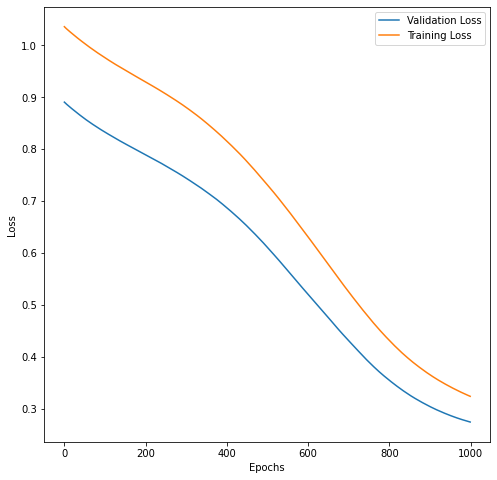

In [15]:
plot_loss(history)

# Task 7: Predictions

## 7.1: Plot Raw Predictions

Let's use the `compare_predictions` helper function to compare predictions from the model when it was untrained and when it was trained.

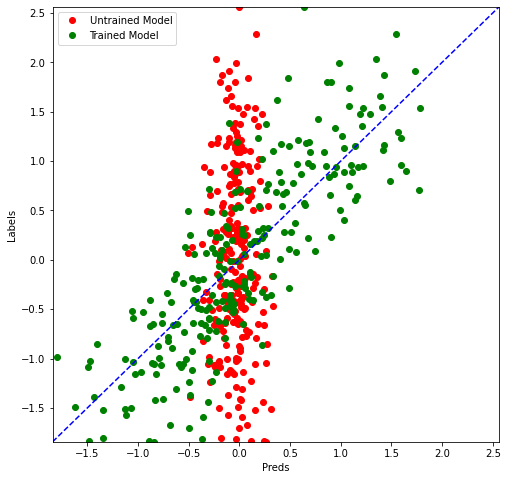

In [16]:
preds_on_trained = model.predict(X_test)

compare_predictions(preds_on_untrained, preds_on_trained, y_test)

## 7.2: Plot Price Predictions

The plot for price predictions and raw predictions will look the same with just one difference: The x and y axis scale is changed.

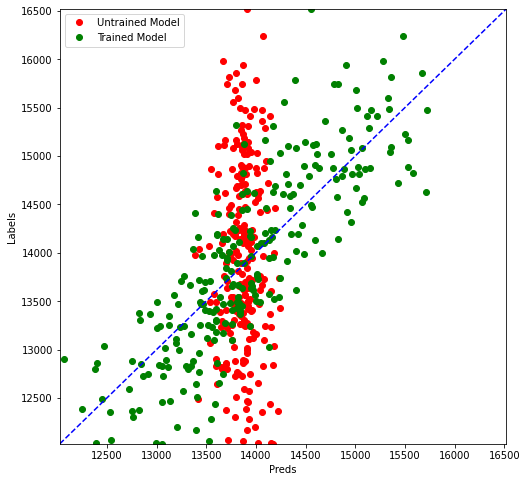

In [17]:
price_on_untrained = [convert_label_value(y) for y in preds_on_untrained]
price_on_trained = [convert_label_value(y) for y in preds_on_trained]
price_y_test = [convert_label_value(y) for y in y_test]

compare_predictions(price_on_untrained, price_on_trained, price_y_test)